# Libraries

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt # plotting library
import random 
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)
torch.set_default_device(device) 
device

device(type='cuda', index=0)

# Data

In [8]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)],torch.Generator(device='cuda'))
batch_size=256



train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,generator = torch.Generator(device='cuda'))
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,generator = torch.Generator(device='cuda'))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True,generator = torch.Generator(device='cuda'))

# Autoencoder Topology 

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Loss function $\mathcal L$

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 10

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# Training

In [11]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

# Testing

In [12]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

# Outputs

In [13]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

# Training loop

	 partial train loss (single batch): 0.249992
	 partial train loss (single batch): 0.242570
	 partial train loss (single batch): 0.236973
	 partial train loss (single batch): 0.232399
	 partial train loss (single batch): 0.227944
	 partial train loss (single batch): 0.223648
	 partial train loss (single batch): 0.221450
	 partial train loss (single batch): 0.218587
	 partial train loss (single batch): 0.215881
	 partial train loss (single batch): 0.213327
	 partial train loss (single batch): 0.210546
	 partial train loss (single batch): 0.207998
	 partial train loss (single batch): 0.206080
	 partial train loss (single batch): 0.203834
	 partial train loss (single batch): 0.201765
	 partial train loss (single batch): 0.200078
	 partial train loss (single batch): 0.198298
	 partial train loss (single batch): 0.196516
	 partial train loss (single batch): 0.194446
	 partial train loss (single batch): 0.192928
	 partial train loss (single batch): 0.190915
	 partial train loss (single batch

	 partial train loss (single batch): 0.066614
	 partial train loss (single batch): 0.065353
	 partial train loss (single batch): 0.065375
	 partial train loss (single batch): 0.065443
	 partial train loss (single batch): 0.064587
	 partial train loss (single batch): 0.064439
	 partial train loss (single batch): 0.064366
	 partial train loss (single batch): 0.064676

 EPOCH 1/30 	 train loss 0.12247548252344131 	 val loss 0.06355872750282288


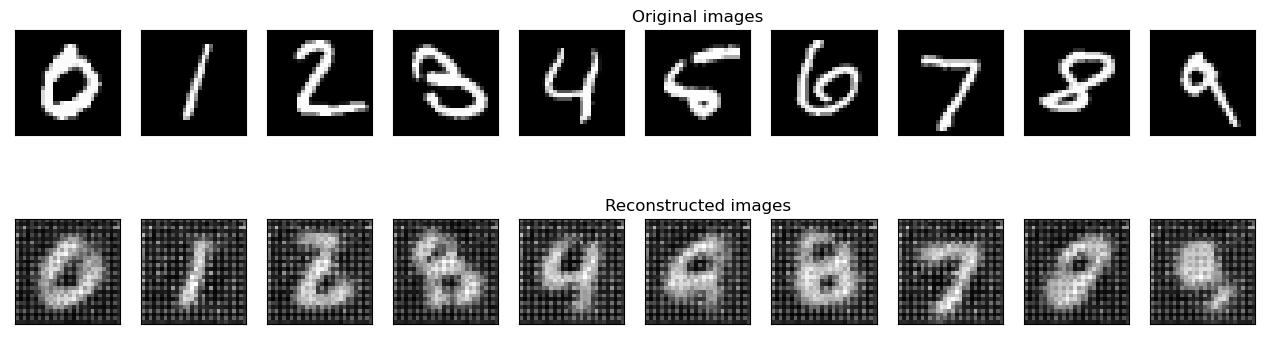

	 partial train loss (single batch): 0.063238
	 partial train loss (single batch): 0.063361
	 partial train loss (single batch): 0.063178
	 partial train loss (single batch): 0.062359
	 partial train loss (single batch): 0.062097
	 partial train loss (single batch): 0.062386
	 partial train loss (single batch): 0.061088
	 partial train loss (single batch): 0.060633
	 partial train loss (single batch): 0.061489
	 partial train loss (single batch): 0.060080
	 partial train loss (single batch): 0.060440
	 partial train loss (single batch): 0.060620
	 partial train loss (single batch): 0.060253
	 partial train loss (single batch): 0.060233
	 partial train loss (single batch): 0.059417
	 partial train loss (single batch): 0.058642
	 partial train loss (single batch): 0.058360
	 partial train loss (single batch): 0.058693
	 partial train loss (single batch): 0.058358
	 partial train loss (single batch): 0.057122
	 partial train loss (single batch): 0.058128
	 partial train loss (single batch

	 partial train loss (single batch): 0.033953
	 partial train loss (single batch): 0.034032
	 partial train loss (single batch): 0.034419
	 partial train loss (single batch): 0.033717
	 partial train loss (single batch): 0.033549
	 partial train loss (single batch): 0.033910
	 partial train loss (single batch): 0.034249

 EPOCH 2/30 	 train loss 0.04505199193954468 	 val loss 0.033686988055706024


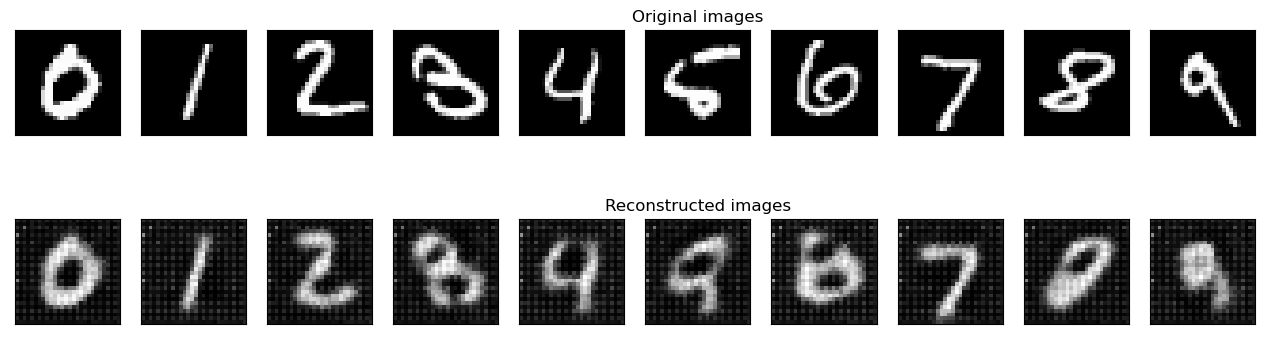

	 partial train loss (single batch): 0.033100
	 partial train loss (single batch): 0.033866
	 partial train loss (single batch): 0.033602
	 partial train loss (single batch): 0.032825
	 partial train loss (single batch): 0.033319
	 partial train loss (single batch): 0.033433
	 partial train loss (single batch): 0.032182
	 partial train loss (single batch): 0.032297
	 partial train loss (single batch): 0.033530
	 partial train loss (single batch): 0.031699
	 partial train loss (single batch): 0.032575
	 partial train loss (single batch): 0.033152
	 partial train loss (single batch): 0.032835
	 partial train loss (single batch): 0.033068
	 partial train loss (single batch): 0.033004
	 partial train loss (single batch): 0.032120
	 partial train loss (single batch): 0.032122
	 partial train loss (single batch): 0.032455
	 partial train loss (single batch): 0.032379
	 partial train loss (single batch): 0.030943
	 partial train loss (single batch): 0.032847
	 partial train loss (single batch

	 partial train loss (single batch): 0.025138
	 partial train loss (single batch): 0.024880
	 partial train loss (single batch): 0.025229
	 partial train loss (single batch): 0.024954
	 partial train loss (single batch): 0.024606
	 partial train loss (single batch): 0.025291
	 partial train loss (single batch): 0.025122

 EPOCH 3/30 	 train loss 0.028366073966026306 	 val loss 0.02532273344695568


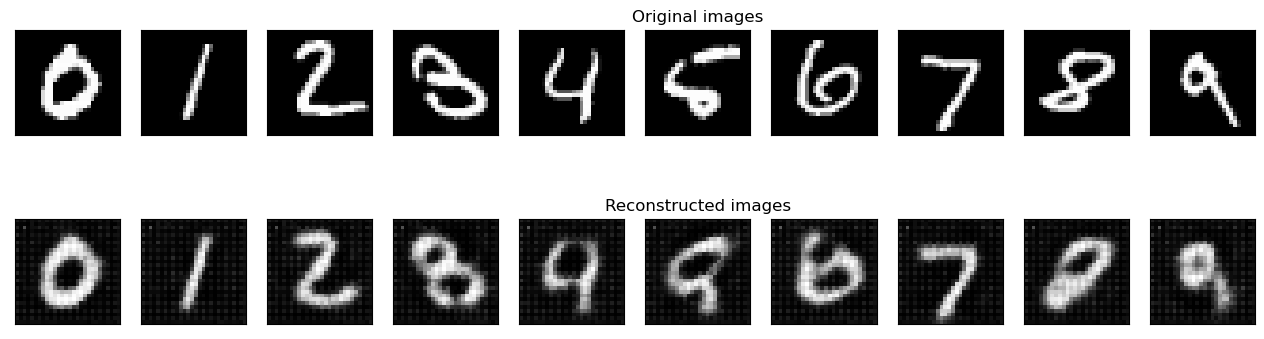

	 partial train loss (single batch): 0.024735
	 partial train loss (single batch): 0.025151
	 partial train loss (single batch): 0.025118
	 partial train loss (single batch): 0.024279
	 partial train loss (single batch): 0.024994
	 partial train loss (single batch): 0.024942
	 partial train loss (single batch): 0.023964
	 partial train loss (single batch): 0.024156
	 partial train loss (single batch): 0.025240
	 partial train loss (single batch): 0.023362
	 partial train loss (single batch): 0.024103
	 partial train loss (single batch): 0.024833
	 partial train loss (single batch): 0.024756
	 partial train loss (single batch): 0.024738
	 partial train loss (single batch): 0.025471
	 partial train loss (single batch): 0.024097
	 partial train loss (single batch): 0.024535
	 partial train loss (single batch): 0.024527
	 partial train loss (single batch): 0.024790
	 partial train loss (single batch): 0.023043
	 partial train loss (single batch): 0.025361
	 partial train loss (single batch

	 partial train loss (single batch): 0.022595
	 partial train loss (single batch): 0.021658
	 partial train loss (single batch): 0.021298
	 partial train loss (single batch): 0.021529
	 partial train loss (single batch): 0.021486
	 partial train loss (single batch): 0.021361
	 partial train loss (single batch): 0.021771
	 partial train loss (single batch): 0.021622

 EPOCH 4/30 	 train loss 0.022915389388799667 	 val loss 0.021806780248880386


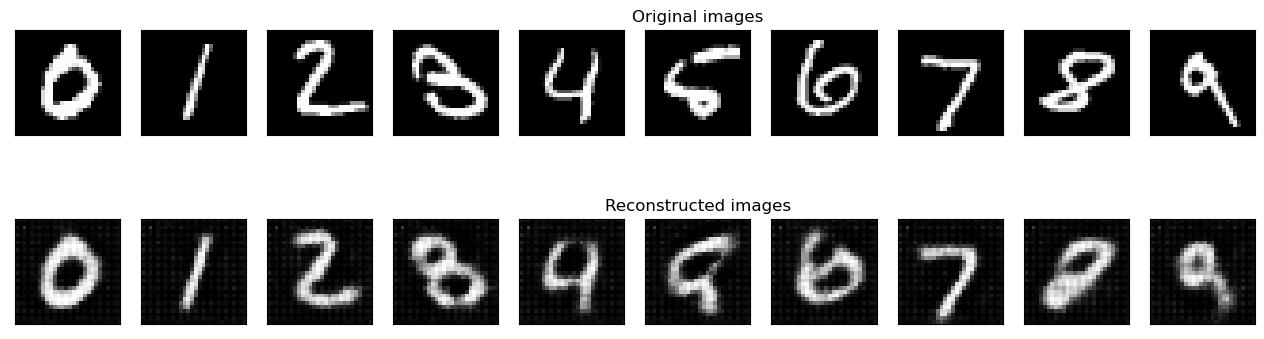

	 partial train loss (single batch): 0.021289
	 partial train loss (single batch): 0.021731
	 partial train loss (single batch): 0.021715
	 partial train loss (single batch): 0.020910
	 partial train loss (single batch): 0.021655
	 partial train loss (single batch): 0.021663
	 partial train loss (single batch): 0.020644
	 partial train loss (single batch): 0.020966
	 partial train loss (single batch): 0.021753
	 partial train loss (single batch): 0.020096
	 partial train loss (single batch): 0.020680
	 partial train loss (single batch): 0.021345
	 partial train loss (single batch): 0.021407
	 partial train loss (single batch): 0.021556
	 partial train loss (single batch): 0.022327
	 partial train loss (single batch): 0.020939
	 partial train loss (single batch): 0.021358
	 partial train loss (single batch): 0.021418
	 partial train loss (single batch): 0.021497
	 partial train loss (single batch): 0.020138
	 partial train loss (single batch): 0.022099
	 partial train loss (single batch

	 partial train loss (single batch): 0.019790
	 partial train loss (single batch): 0.019537
	 partial train loss (single batch): 0.019701
	 partial train loss (single batch): 0.019744
	 partial train loss (single batch): 0.019622
	 partial train loss (single batch): 0.020007
	 partial train loss (single batch): 0.019860

 EPOCH 5/30 	 train loss 0.02039894089102745 	 val loss 0.019962036982178688


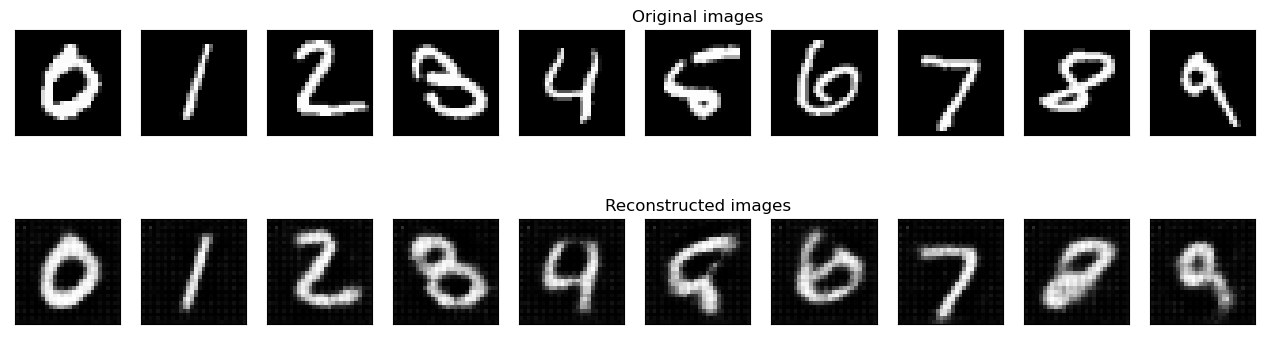

	 partial train loss (single batch): 0.019454
	 partial train loss (single batch): 0.019880
	 partial train loss (single batch): 0.019742
	 partial train loss (single batch): 0.019065
	 partial train loss (single batch): 0.019880
	 partial train loss (single batch): 0.019770
	 partial train loss (single batch): 0.018986
	 partial train loss (single batch): 0.019141
	 partial train loss (single batch): 0.020041
	 partial train loss (single batch): 0.018251
	 partial train loss (single batch): 0.018936
	 partial train loss (single batch): 0.019527
	 partial train loss (single batch): 0.019558
	 partial train loss (single batch): 0.019780
	 partial train loss (single batch): 0.020434
	 partial train loss (single batch): 0.019175
	 partial train loss (single batch): 0.019618
	 partial train loss (single batch): 0.019618
	 partial train loss (single batch): 0.019892
	 partial train loss (single batch): 0.018503
	 partial train loss (single batch): 0.020276
	 partial train loss (single batch

	 partial train loss (single batch): 0.018445
	 partial train loss (single batch): 0.018492
	 partial train loss (single batch): 0.018544
	 partial train loss (single batch): 0.018526
	 partial train loss (single batch): 0.018858
	 partial train loss (single batch): 0.018628

 EPOCH 6/30 	 train loss 0.01894509606063366 	 val loss 0.018716000020503998


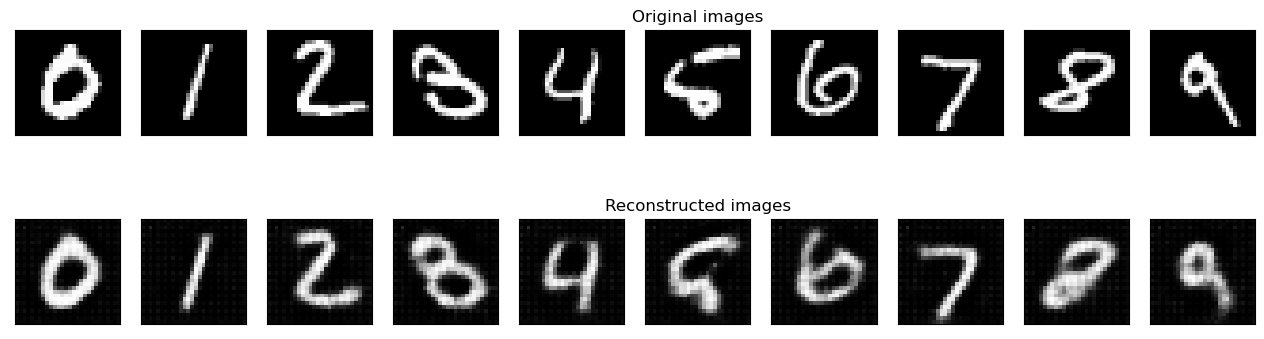

	 partial train loss (single batch): 0.018251
	 partial train loss (single batch): 0.018660
	 partial train loss (single batch): 0.018526
	 partial train loss (single batch): 0.017744
	 partial train loss (single batch): 0.018769
	 partial train loss (single batch): 0.018664
	 partial train loss (single batch): 0.017928
	 partial train loss (single batch): 0.017971
	 partial train loss (single batch): 0.018845
	 partial train loss (single batch): 0.017175
	 partial train loss (single batch): 0.017765
	 partial train loss (single batch): 0.018375
	 partial train loss (single batch): 0.018341
	 partial train loss (single batch): 0.018652
	 partial train loss (single batch): 0.019123
	 partial train loss (single batch): 0.017989
	 partial train loss (single batch): 0.018427
	 partial train loss (single batch): 0.018517
	 partial train loss (single batch): 0.018755
	 partial train loss (single batch): 0.017354
	 partial train loss (single batch): 0.019095
	 partial train loss (single batch

	 partial train loss (single batch): 0.018673
	 partial train loss (single batch): 0.018961
	 partial train loss (single batch): 0.017744
	 partial train loss (single batch): 0.017498
	 partial train loss (single batch): 0.017649
	 partial train loss (single batch): 0.017641
	 partial train loss (single batch): 0.017727
	 partial train loss (single batch): 0.018066
	 partial train loss (single batch): 0.017768

 EPOCH 7/30 	 train loss 0.017927756533026695 	 val loss 0.01790495403110981


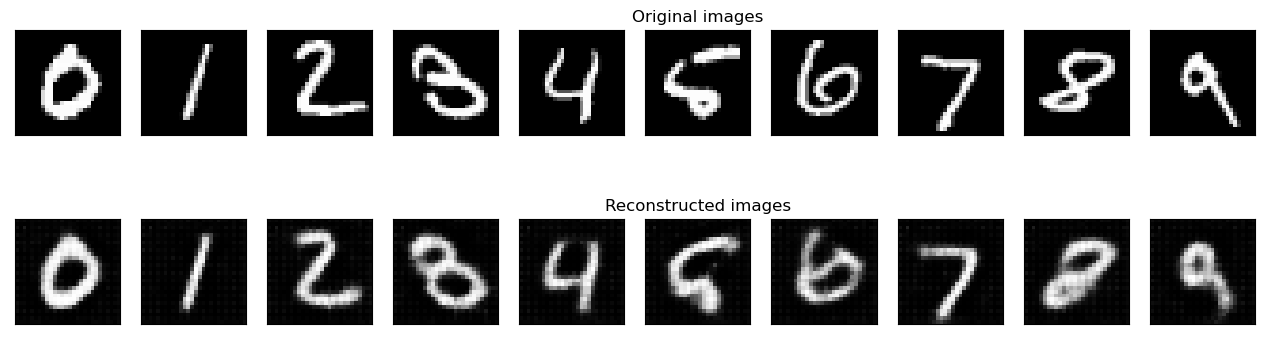

	 partial train loss (single batch): 0.017501
	 partial train loss (single batch): 0.017761
	 partial train loss (single batch): 0.017728
	 partial train loss (single batch): 0.016873
	 partial train loss (single batch): 0.017948
	 partial train loss (single batch): 0.017843
	 partial train loss (single batch): 0.017073
	 partial train loss (single batch): 0.017152
	 partial train loss (single batch): 0.017825
	 partial train loss (single batch): 0.016346
	 partial train loss (single batch): 0.016948
	 partial train loss (single batch): 0.017472
	 partial train loss (single batch): 0.017411
	 partial train loss (single batch): 0.017827
	 partial train loss (single batch): 0.018210
	 partial train loss (single batch): 0.017194
	 partial train loss (single batch): 0.017543
	 partial train loss (single batch): 0.017662
	 partial train loss (single batch): 0.017896
	 partial train loss (single batch): 0.016484
	 partial train loss (single batch): 0.018285
	 partial train loss (single batch

	 partial train loss (single batch): 0.016978
	 partial train loss (single batch): 0.016994
	 partial train loss (single batch): 0.017124
	 partial train loss (single batch): 0.017500
	 partial train loss (single batch): 0.017051

 EPOCH 8/30 	 train loss 0.017195148393511772 	 val loss 0.017466766759753227


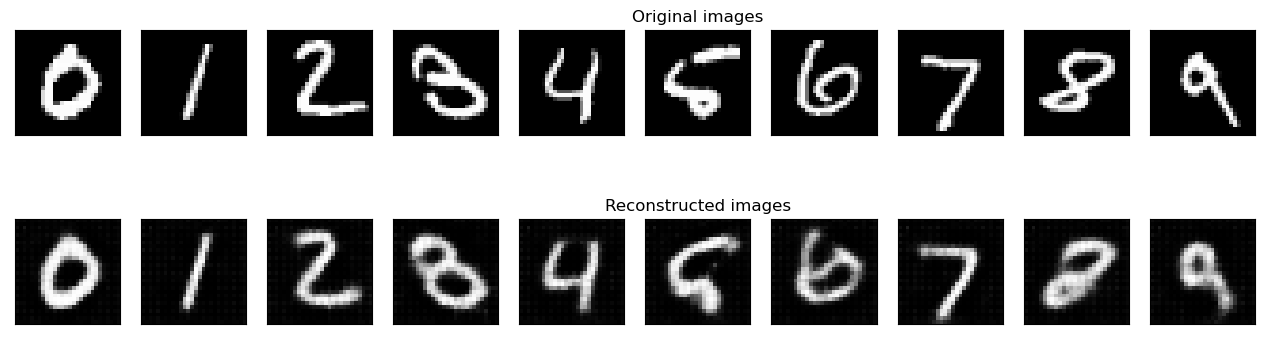

	 partial train loss (single batch): 0.017082
	 partial train loss (single batch): 0.017046
	 partial train loss (single batch): 0.017070
	 partial train loss (single batch): 0.016210
	 partial train loss (single batch): 0.017327
	 partial train loss (single batch): 0.017227
	 partial train loss (single batch): 0.016499
	 partial train loss (single batch): 0.016476
	 partial train loss (single batch): 0.017099
	 partial train loss (single batch): 0.015744
	 partial train loss (single batch): 0.016298
	 partial train loss (single batch): 0.016794
	 partial train loss (single batch): 0.016684
	 partial train loss (single batch): 0.017083
	 partial train loss (single batch): 0.017566
	 partial train loss (single batch): 0.016498
	 partial train loss (single batch): 0.016844
	 partial train loss (single batch): 0.016979
	 partial train loss (single batch): 0.017164
	 partial train loss (single batch): 0.015783
	 partial train loss (single batch): 0.017448
	 partial train loss (single batch

	 partial train loss (single batch): 0.016706
	 partial train loss (single batch): 0.016141
	 partial train loss (single batch): 0.016380
	 partial train loss (single batch): 0.016529
	 partial train loss (single batch): 0.016497
	 partial train loss (single batch): 0.016891
	 partial train loss (single batch): 0.016537

 EPOCH 9/30 	 train loss 0.01659484952688217 	 val loss 0.016752364113926888


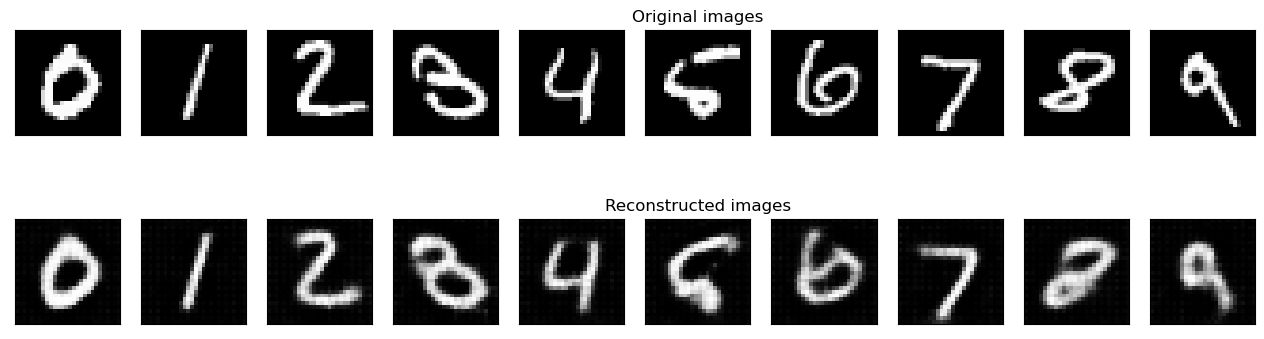

	 partial train loss (single batch): 0.016352
	 partial train loss (single batch): 0.016396
	 partial train loss (single batch): 0.016431
	 partial train loss (single batch): 0.015668
	 partial train loss (single batch): 0.016792
	 partial train loss (single batch): 0.016770
	 partial train loss (single batch): 0.015873
	 partial train loss (single batch): 0.016063
	 partial train loss (single batch): 0.016441
	 partial train loss (single batch): 0.015191
	 partial train loss (single batch): 0.015802
	 partial train loss (single batch): 0.016274
	 partial train loss (single batch): 0.016241
	 partial train loss (single batch): 0.016579
	 partial train loss (single batch): 0.017055
	 partial train loss (single batch): 0.015969
	 partial train loss (single batch): 0.016389
	 partial train loss (single batch): 0.016416
	 partial train loss (single batch): 0.016663
	 partial train loss (single batch): 0.015193
	 partial train loss (single batch): 0.016939
	 partial train loss (single batch

	 partial train loss (single batch): 0.016798
	 partial train loss (single batch): 0.017461
	 partial train loss (single batch): 0.016355
	 partial train loss (single batch): 0.015663
	 partial train loss (single batch): 0.015955
	 partial train loss (single batch): 0.016121
	 partial train loss (single batch): 0.016100
	 partial train loss (single batch): 0.016475
	 partial train loss (single batch): 0.016005

 EPOCH 10/30 	 train loss 0.016101514920592308 	 val loss 0.01640326902270317


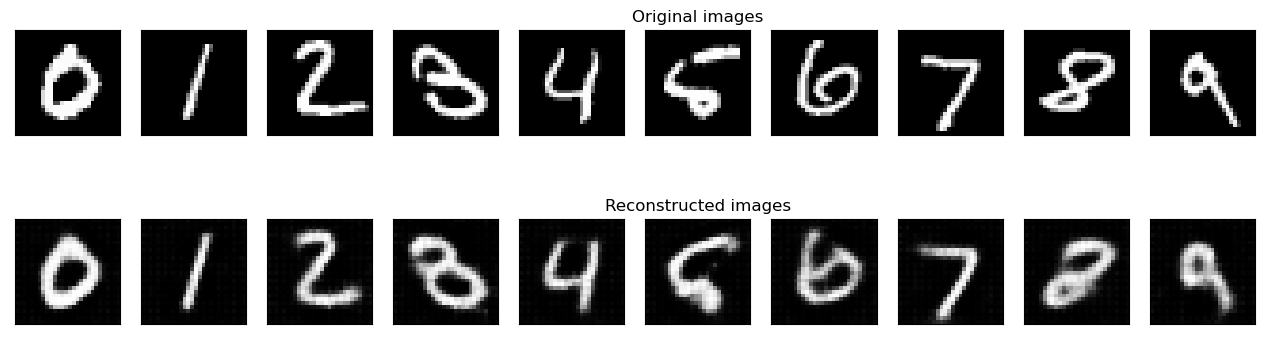

	 partial train loss (single batch): 0.015983
	 partial train loss (single batch): 0.015909
	 partial train loss (single batch): 0.016040
	 partial train loss (single batch): 0.015304
	 partial train loss (single batch): 0.016457
	 partial train loss (single batch): 0.016322
	 partial train loss (single batch): 0.015508
	 partial train loss (single batch): 0.015642
	 partial train loss (single batch): 0.015997
	 partial train loss (single batch): 0.014794
	 partial train loss (single batch): 0.015431
	 partial train loss (single batch): 0.015743
	 partial train loss (single batch): 0.015842
	 partial train loss (single batch): 0.016073
	 partial train loss (single batch): 0.016621
	 partial train loss (single batch): 0.015600
	 partial train loss (single batch): 0.016052
	 partial train loss (single batch): 0.015947
	 partial train loss (single batch): 0.016225
	 partial train loss (single batch): 0.014765
	 partial train loss (single batch): 0.016545
	 partial train loss (single batch

	 partial train loss (single batch): 0.015788
	 partial train loss (single batch): 0.015792
	 partial train loss (single batch): 0.016180
	 partial train loss (single batch): 0.015647

 EPOCH 11/30 	 train loss 0.015702204778790474 	 val loss 0.016019733622670174


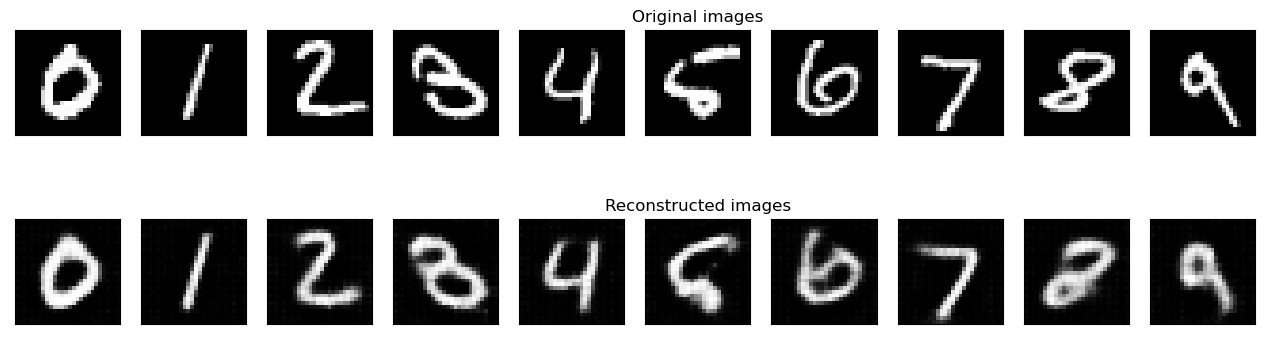

	 partial train loss (single batch): 0.015613
	 partial train loss (single batch): 0.015518
	 partial train loss (single batch): 0.015711
	 partial train loss (single batch): 0.014962
	 partial train loss (single batch): 0.016135
	 partial train loss (single batch): 0.015951
	 partial train loss (single batch): 0.015165
	 partial train loss (single batch): 0.015327
	 partial train loss (single batch): 0.015620
	 partial train loss (single batch): 0.014452
	 partial train loss (single batch): 0.015088
	 partial train loss (single batch): 0.015344
	 partial train loss (single batch): 0.015501
	 partial train loss (single batch): 0.015737
	 partial train loss (single batch): 0.016212
	 partial train loss (single batch): 0.015230
	 partial train loss (single batch): 0.015701
	 partial train loss (single batch): 0.015596
	 partial train loss (single batch): 0.015880
	 partial train loss (single batch): 0.014415
	 partial train loss (single batch): 0.016194
	 partial train loss (single batch

	 partial train loss (single batch): 0.015768
	 partial train loss (single batch): 0.015047
	 partial train loss (single batch): 0.015274
	 partial train loss (single batch): 0.015460
	 partial train loss (single batch): 0.015580
	 partial train loss (single batch): 0.015855
	 partial train loss (single batch): 0.015320

 EPOCH 12/30 	 train loss 0.015373830683529377 	 val loss 0.015692507848143578


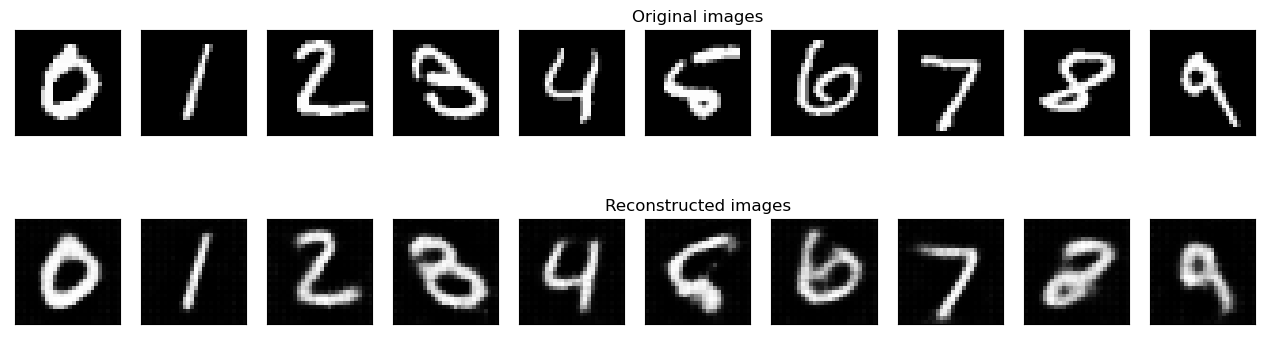

	 partial train loss (single batch): 0.015324
	 partial train loss (single batch): 0.015246
	 partial train loss (single batch): 0.015396
	 partial train loss (single batch): 0.014673
	 partial train loss (single batch): 0.015785
	 partial train loss (single batch): 0.015593
	 partial train loss (single batch): 0.014855
	 partial train loss (single batch): 0.015076
	 partial train loss (single batch): 0.015324
	 partial train loss (single batch): 0.014189
	 partial train loss (single batch): 0.014808
	 partial train loss (single batch): 0.015040
	 partial train loss (single batch): 0.015166
	 partial train loss (single batch): 0.015415
	 partial train loss (single batch): 0.015928
	 partial train loss (single batch): 0.014946
	 partial train loss (single batch): 0.015432
	 partial train loss (single batch): 0.015324
	 partial train loss (single batch): 0.015590
	 partial train loss (single batch): 0.014160
	 partial train loss (single batch): 0.015949
	 partial train loss (single batch

	 partial train loss (single batch): 0.016484
	 partial train loss (single batch): 0.015507
	 partial train loss (single batch): 0.014761
	 partial train loss (single batch): 0.014942
	 partial train loss (single batch): 0.015153
	 partial train loss (single batch): 0.015230
	 partial train loss (single batch): 0.015611
	 partial train loss (single batch): 0.014965

 EPOCH 13/30 	 train loss 0.01507781632244587 	 val loss 0.015450225211679935


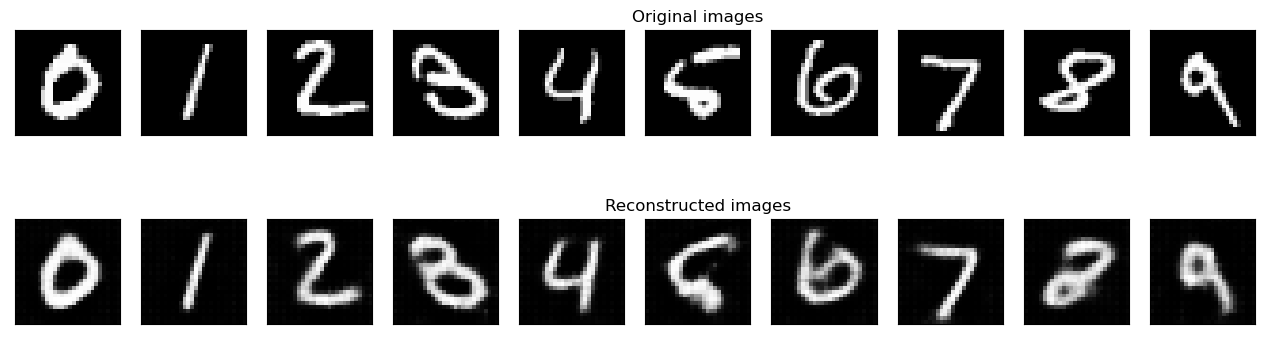

	 partial train loss (single batch): 0.015046
	 partial train loss (single batch): 0.014926
	 partial train loss (single batch): 0.015105
	 partial train loss (single batch): 0.014393
	 partial train loss (single batch): 0.015514
	 partial train loss (single batch): 0.015286
	 partial train loss (single batch): 0.014601
	 partial train loss (single batch): 0.014816
	 partial train loss (single batch): 0.015052
	 partial train loss (single batch): 0.013959
	 partial train loss (single batch): 0.014493
	 partial train loss (single batch): 0.014770
	 partial train loss (single batch): 0.014903
	 partial train loss (single batch): 0.015149
	 partial train loss (single batch): 0.015620
	 partial train loss (single batch): 0.014686
	 partial train loss (single batch): 0.015206
	 partial train loss (single batch): 0.015079
	 partial train loss (single batch): 0.015341
	 partial train loss (single batch): 0.013897
	 partial train loss (single batch): 0.015706
	 partial train loss (single batch

	 partial train loss (single batch): 0.014489
	 partial train loss (single batch): 0.014708
	 partial train loss (single batch): 0.014898
	 partial train loss (single batch): 0.014962
	 partial train loss (single batch): 0.015407
	 partial train loss (single batch): 0.014704

 EPOCH 14/30 	 train loss 0.014815344475209713 	 val loss 0.015227550640702248


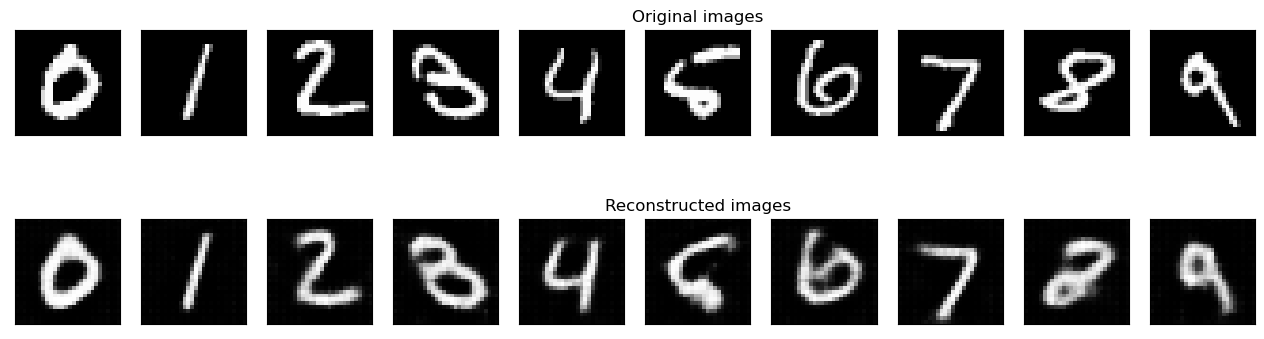

	 partial train loss (single batch): 0.014828
	 partial train loss (single batch): 0.014721
	 partial train loss (single batch): 0.014843
	 partial train loss (single batch): 0.014193
	 partial train loss (single batch): 0.015286
	 partial train loss (single batch): 0.015030
	 partial train loss (single batch): 0.014343
	 partial train loss (single batch): 0.014578
	 partial train loss (single batch): 0.014827
	 partial train loss (single batch): 0.013790
	 partial train loss (single batch): 0.014297
	 partial train loss (single batch): 0.014560
	 partial train loss (single batch): 0.014686
	 partial train loss (single batch): 0.014959
	 partial train loss (single batch): 0.015409
	 partial train loss (single batch): 0.014503
	 partial train loss (single batch): 0.015000
	 partial train loss (single batch): 0.014826
	 partial train loss (single batch): 0.015125
	 partial train loss (single batch): 0.013676
	 partial train loss (single batch): 0.015486
	 partial train loss (single batch

	 partial train loss (single batch): 0.014244
	 partial train loss (single batch): 0.014418
	 partial train loss (single batch): 0.014616
	 partial train loss (single batch): 0.014740
	 partial train loss (single batch): 0.015148
	 partial train loss (single batch): 0.014493

 EPOCH 15/30 	 train loss 0.01459434349089861 	 val loss 0.014978187158703804


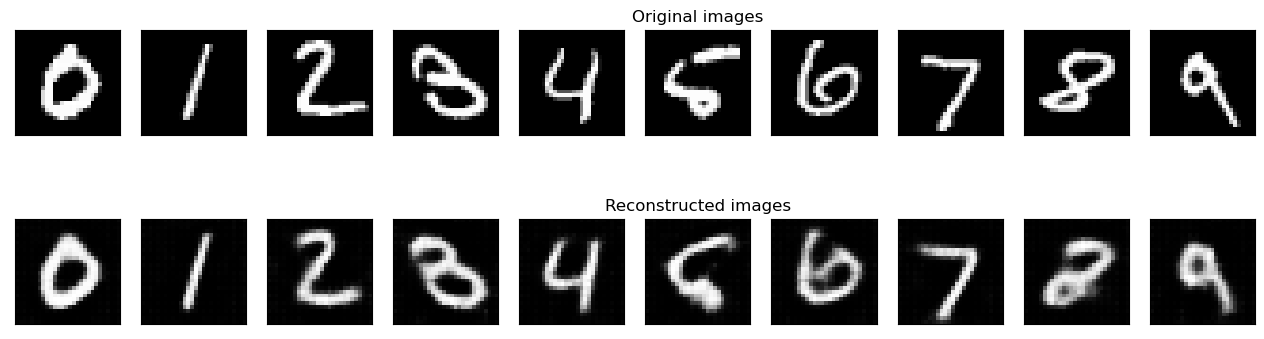

	 partial train loss (single batch): 0.014612
	 partial train loss (single batch): 0.014499
	 partial train loss (single batch): 0.014587
	 partial train loss (single batch): 0.013983
	 partial train loss (single batch): 0.015029
	 partial train loss (single batch): 0.014784
	 partial train loss (single batch): 0.014097
	 partial train loss (single batch): 0.014364
	 partial train loss (single batch): 0.014587
	 partial train loss (single batch): 0.013611
	 partial train loss (single batch): 0.014067
	 partial train loss (single batch): 0.014351
	 partial train loss (single batch): 0.014461
	 partial train loss (single batch): 0.014741
	 partial train loss (single batch): 0.015206
	 partial train loss (single batch): 0.014304
	 partial train loss (single batch): 0.014753
	 partial train loss (single batch): 0.014590
	 partial train loss (single batch): 0.014913
	 partial train loss (single batch): 0.013483
	 partial train loss (single batch): 0.015269
	 partial train loss (single batch

	 partial train loss (single batch): 0.014084
	 partial train loss (single batch): 0.014192
	 partial train loss (single batch): 0.014444
	 partial train loss (single batch): 0.014571
	 partial train loss (single batch): 0.014949
	 partial train loss (single batch): 0.014327

 EPOCH 16/30 	 train loss 0.014397495426237583 	 val loss 0.014729492366313934


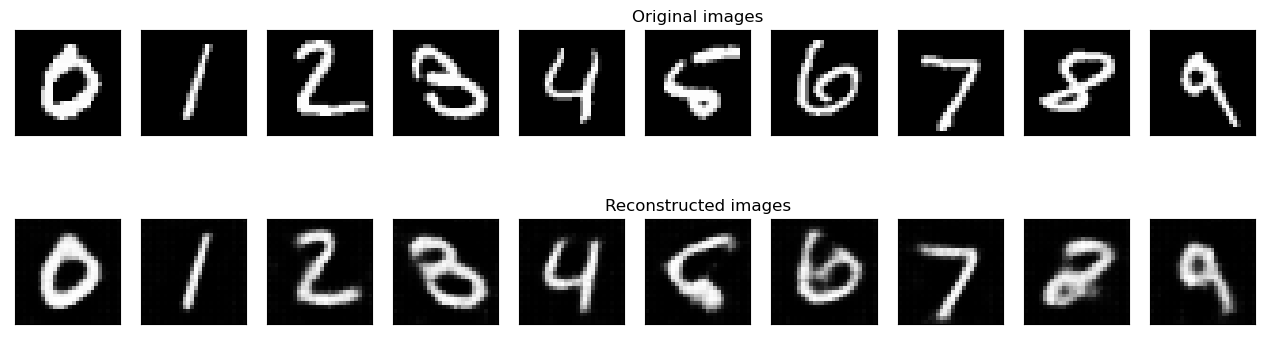

	 partial train loss (single batch): 0.014401
	 partial train loss (single batch): 0.014319
	 partial train loss (single batch): 0.014404
	 partial train loss (single batch): 0.013862
	 partial train loss (single batch): 0.014812
	 partial train loss (single batch): 0.014541
	 partial train loss (single batch): 0.013898
	 partial train loss (single batch): 0.014149
	 partial train loss (single batch): 0.014393
	 partial train loss (single batch): 0.013465
	 partial train loss (single batch): 0.013881
	 partial train loss (single batch): 0.014138
	 partial train loss (single batch): 0.014303
	 partial train loss (single batch): 0.014550
	 partial train loss (single batch): 0.015032
	 partial train loss (single batch): 0.014122
	 partial train loss (single batch): 0.014594
	 partial train loss (single batch): 0.014399
	 partial train loss (single batch): 0.014768
	 partial train loss (single batch): 0.013282
	 partial train loss (single batch): 0.015143
	 partial train loss (single batch

	 partial train loss (single batch): 0.013890
	 partial train loss (single batch): 0.014023
	 partial train loss (single batch): 0.014262
	 partial train loss (single batch): 0.014408
	 partial train loss (single batch): 0.014746
	 partial train loss (single batch): 0.014186

 EPOCH 17/30 	 train loss 0.014232972636818886 	 val loss 0.014591257087886333


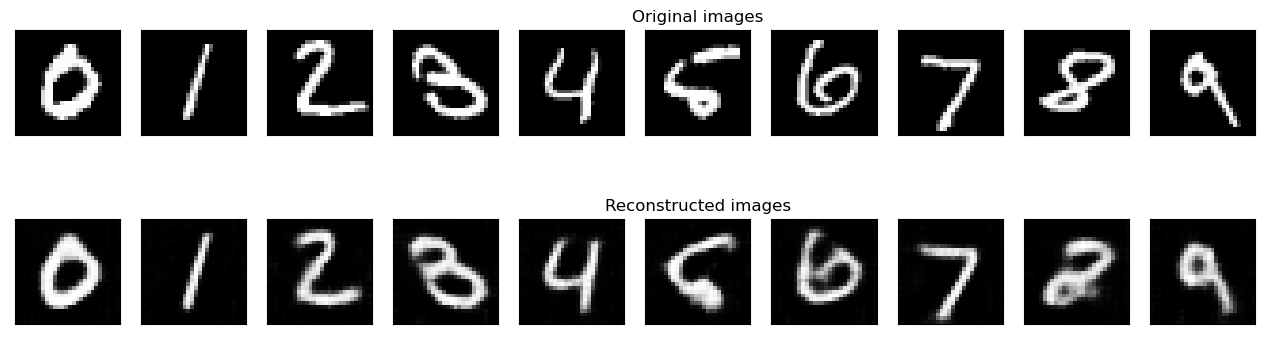

	 partial train loss (single batch): 0.014256
	 partial train loss (single batch): 0.014194
	 partial train loss (single batch): 0.014235
	 partial train loss (single batch): 0.013712
	 partial train loss (single batch): 0.014626
	 partial train loss (single batch): 0.014385
	 partial train loss (single batch): 0.013768
	 partial train loss (single batch): 0.013988
	 partial train loss (single batch): 0.014230
	 partial train loss (single batch): 0.013341
	 partial train loss (single batch): 0.013694
	 partial train loss (single batch): 0.013985
	 partial train loss (single batch): 0.014091
	 partial train loss (single batch): 0.014426
	 partial train loss (single batch): 0.014856
	 partial train loss (single batch): 0.013944
	 partial train loss (single batch): 0.014395
	 partial train loss (single batch): 0.014216
	 partial train loss (single batch): 0.014591
	 partial train loss (single batch): 0.013138
	 partial train loss (single batch): 0.014944
	 partial train loss (single batch

	 partial train loss (single batch): 0.014078
	 partial train loss (single batch): 0.014253
	 partial train loss (single batch): 0.014603
	 partial train loss (single batch): 0.013997

 EPOCH 18/30 	 train loss 0.014084973372519016 	 val loss 0.014544695615768433


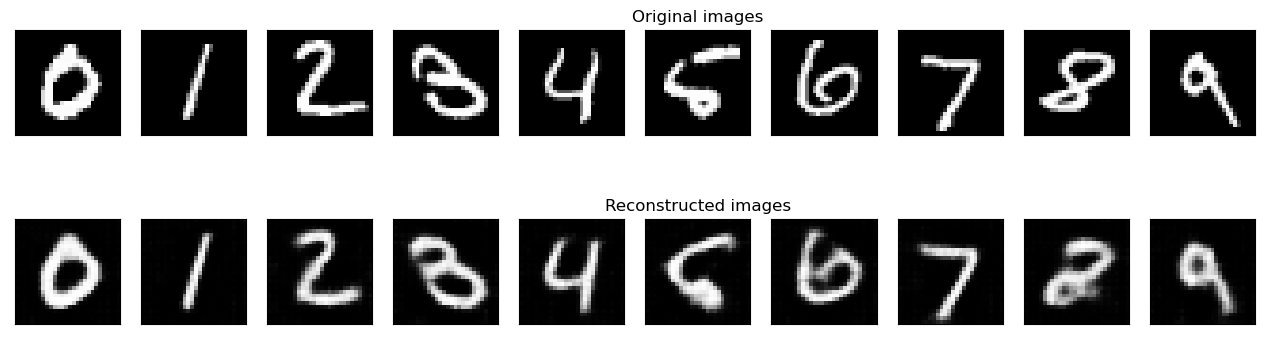

	 partial train loss (single batch): 0.014145
	 partial train loss (single batch): 0.014040
	 partial train loss (single batch): 0.014086
	 partial train loss (single batch): 0.013628
	 partial train loss (single batch): 0.014488
	 partial train loss (single batch): 0.014283
	 partial train loss (single batch): 0.013661
	 partial train loss (single batch): 0.013895
	 partial train loss (single batch): 0.014100
	 partial train loss (single batch): 0.013211
	 partial train loss (single batch): 0.013570
	 partial train loss (single batch): 0.013874
	 partial train loss (single batch): 0.013927
	 partial train loss (single batch): 0.014289
	 partial train loss (single batch): 0.014697
	 partial train loss (single batch): 0.013815
	 partial train loss (single batch): 0.014228
	 partial train loss (single batch): 0.014052
	 partial train loss (single batch): 0.014501
	 partial train loss (single batch): 0.013031
	 partial train loss (single batch): 0.014819
	 partial train loss (single batch

	 partial train loss (single batch): 0.014582
	 partial train loss (single batch): 0.013600
	 partial train loss (single batch): 0.013729
	 partial train loss (single batch): 0.013942
	 partial train loss (single batch): 0.014121
	 partial train loss (single batch): 0.014464
	 partial train loss (single batch): 0.013926

 EPOCH 19/30 	 train loss 0.013962682336568832 	 val loss 0.014394537545740604


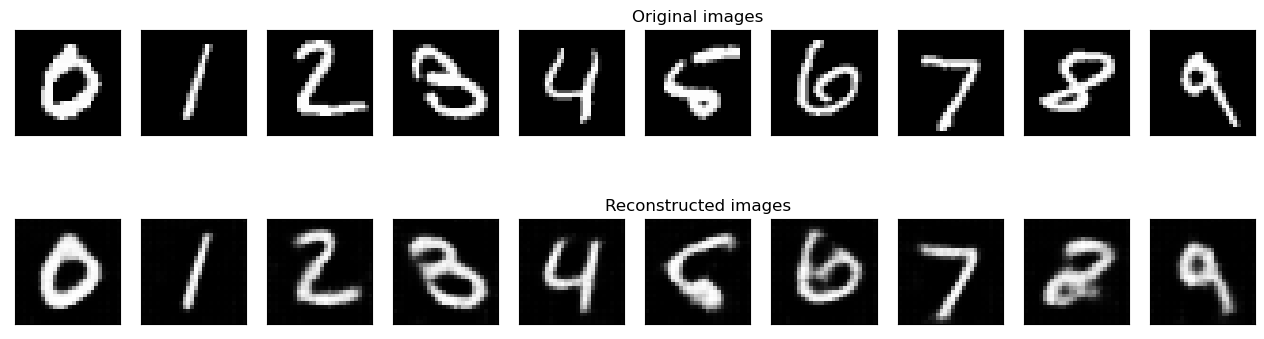

	 partial train loss (single batch): 0.014012
	 partial train loss (single batch): 0.013928
	 partial train loss (single batch): 0.013922
	 partial train loss (single batch): 0.013558
	 partial train loss (single batch): 0.014335
	 partial train loss (single batch): 0.014238
	 partial train loss (single batch): 0.013518
	 partial train loss (single batch): 0.013797
	 partial train loss (single batch): 0.013989
	 partial train loss (single batch): 0.013117
	 partial train loss (single batch): 0.013444
	 partial train loss (single batch): 0.013807
	 partial train loss (single batch): 0.013767
	 partial train loss (single batch): 0.014223
	 partial train loss (single batch): 0.014575
	 partial train loss (single batch): 0.013762
	 partial train loss (single batch): 0.014037
	 partial train loss (single batch): 0.013962
	 partial train loss (single batch): 0.014369
	 partial train loss (single batch): 0.012893
	 partial train loss (single batch): 0.014683
	 partial train loss (single batch

	 partial train loss (single batch): 0.013504
	 partial train loss (single batch): 0.013538
	 partial train loss (single batch): 0.013826
	 partial train loss (single batch): 0.014013
	 partial train loss (single batch): 0.014331
	 partial train loss (single batch): 0.013782

 EPOCH 20/30 	 train loss 0.013837680220603943 	 val loss 0.014231435023248196


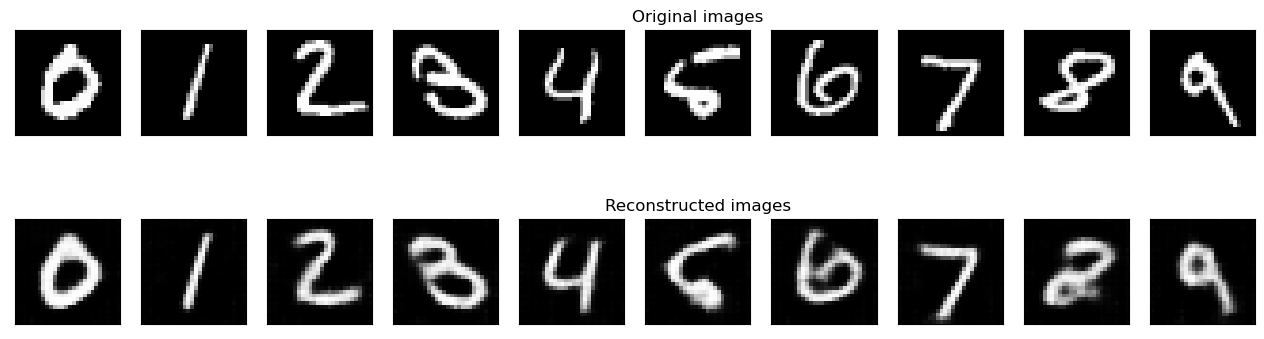

	 partial train loss (single batch): 0.013864
	 partial train loss (single batch): 0.013829
	 partial train loss (single batch): 0.013764
	 partial train loss (single batch): 0.013443
	 partial train loss (single batch): 0.014191
	 partial train loss (single batch): 0.014096
	 partial train loss (single batch): 0.013414
	 partial train loss (single batch): 0.013667
	 partial train loss (single batch): 0.013873
	 partial train loss (single batch): 0.013016
	 partial train loss (single batch): 0.013274
	 partial train loss (single batch): 0.013718
	 partial train loss (single batch): 0.013617
	 partial train loss (single batch): 0.014141
	 partial train loss (single batch): 0.014468
	 partial train loss (single batch): 0.013630
	 partial train loss (single batch): 0.013882
	 partial train loss (single batch): 0.013806
	 partial train loss (single batch): 0.014271
	 partial train loss (single batch): 0.012723
	 partial train loss (single batch): 0.014568
	 partial train loss (single batch

	 partial train loss (single batch): 0.013410
	 partial train loss (single batch): 0.013364
	 partial train loss (single batch): 0.013701
	 partial train loss (single batch): 0.013919
	 partial train loss (single batch): 0.014243
	 partial train loss (single batch): 0.013636

 EPOCH 21/30 	 train loss 0.013737496919929981 	 val loss 0.01409595925360918


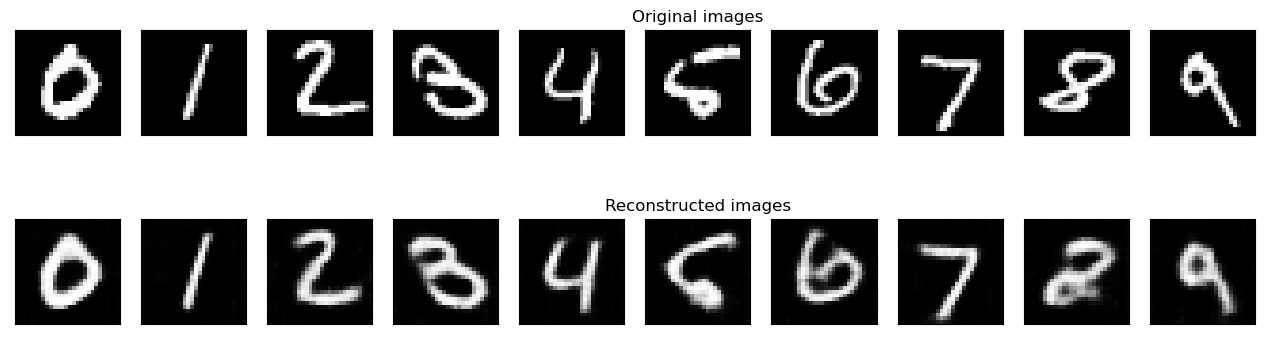

	 partial train loss (single batch): 0.013745
	 partial train loss (single batch): 0.013704
	 partial train loss (single batch): 0.013653
	 partial train loss (single batch): 0.013266
	 partial train loss (single batch): 0.014104
	 partial train loss (single batch): 0.013996
	 partial train loss (single batch): 0.013304
	 partial train loss (single batch): 0.013580
	 partial train loss (single batch): 0.013825
	 partial train loss (single batch): 0.012926
	 partial train loss (single batch): 0.013154
	 partial train loss (single batch): 0.013633
	 partial train loss (single batch): 0.013507
	 partial train loss (single batch): 0.013972
	 partial train loss (single batch): 0.014371
	 partial train loss (single batch): 0.013466
	 partial train loss (single batch): 0.013758
	 partial train loss (single batch): 0.013678
	 partial train loss (single batch): 0.014200
	 partial train loss (single batch): 0.012619
	 partial train loss (single batch): 0.014460
	 partial train loss (single batch

	 partial train loss (single batch): 0.014654
	 partial train loss (single batch): 0.014204
	 partial train loss (single batch): 0.013330
	 partial train loss (single batch): 0.013315
	 partial train loss (single batch): 0.013639
	 partial train loss (single batch): 0.013822
	 partial train loss (single batch): 0.014184
	 partial train loss (single batch): 0.013541

 EPOCH 22/30 	 train loss 0.013635148294270039 	 val loss 0.014043505303561687


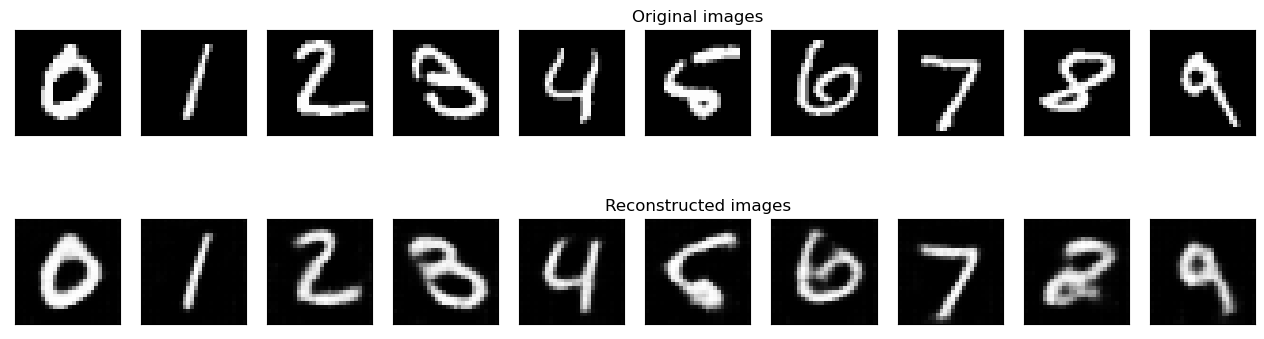

	 partial train loss (single batch): 0.013671
	 partial train loss (single batch): 0.013638
	 partial train loss (single batch): 0.013579
	 partial train loss (single batch): 0.013128
	 partial train loss (single batch): 0.013953
	 partial train loss (single batch): 0.013921
	 partial train loss (single batch): 0.013219
	 partial train loss (single batch): 0.013520
	 partial train loss (single batch): 0.013734
	 partial train loss (single batch): 0.012885
	 partial train loss (single batch): 0.013051
	 partial train loss (single batch): 0.013508
	 partial train loss (single batch): 0.013417
	 partial train loss (single batch): 0.013831
	 partial train loss (single batch): 0.014285
	 partial train loss (single batch): 0.013336
	 partial train loss (single batch): 0.013625
	 partial train loss (single batch): 0.013571
	 partial train loss (single batch): 0.014062
	 partial train loss (single batch): 0.012536
	 partial train loss (single batch): 0.014310
	 partial train loss (single batch

	 partial train loss (single batch): 0.014567
	 partial train loss (single batch): 0.014148
	 partial train loss (single batch): 0.013205
	 partial train loss (single batch): 0.013274
	 partial train loss (single batch): 0.013563
	 partial train loss (single batch): 0.013733
	 partial train loss (single batch): 0.014036
	 partial train loss (single batch): 0.013465

 EPOCH 23/30 	 train loss 0.01353747583925724 	 val loss 0.014012637548148632


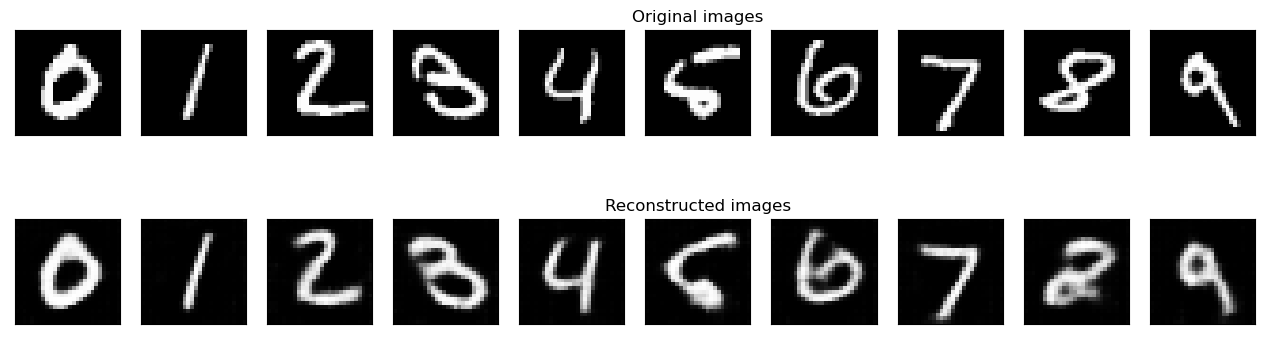

	 partial train loss (single batch): 0.013599
	 partial train loss (single batch): 0.013519
	 partial train loss (single batch): 0.013439
	 partial train loss (single batch): 0.013048
	 partial train loss (single batch): 0.013828
	 partial train loss (single batch): 0.013846
	 partial train loss (single batch): 0.013193
	 partial train loss (single batch): 0.013412
	 partial train loss (single batch): 0.013646
	 partial train loss (single batch): 0.012781
	 partial train loss (single batch): 0.012955
	 partial train loss (single batch): 0.013356
	 partial train loss (single batch): 0.013329
	 partial train loss (single batch): 0.013695
	 partial train loss (single batch): 0.014137
	 partial train loss (single batch): 0.013271
	 partial train loss (single batch): 0.013437
	 partial train loss (single batch): 0.013486
	 partial train loss (single batch): 0.013962
	 partial train loss (single batch): 0.012444
	 partial train loss (single batch): 0.014248
	 partial train loss (single batch

	 partial train loss (single batch): 0.014179
	 partial train loss (single batch): 0.014473
	 partial train loss (single batch): 0.014044
	 partial train loss (single batch): 0.013094
	 partial train loss (single batch): 0.013150
	 partial train loss (single batch): 0.013505
	 partial train loss (single batch): 0.013615
	 partial train loss (single batch): 0.013913
	 partial train loss (single batch): 0.013381

 EPOCH 24/30 	 train loss 0.013428617268800735 	 val loss 0.013900887221097946


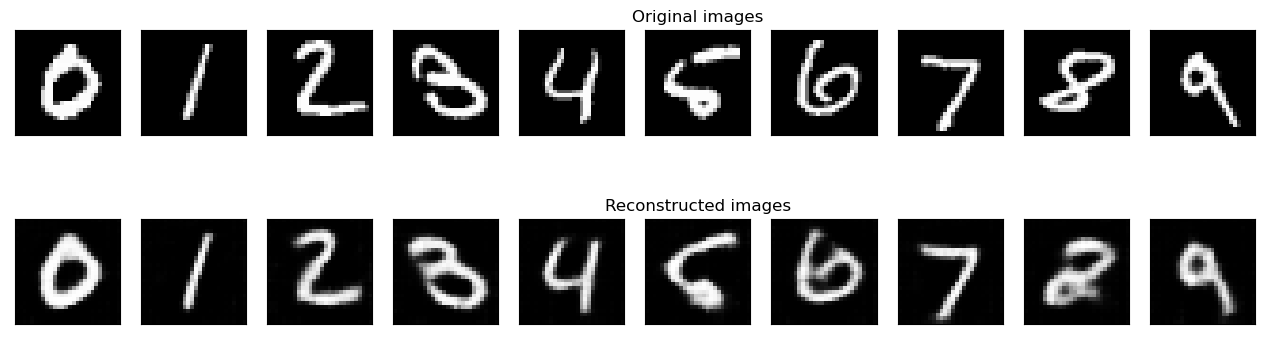

	 partial train loss (single batch): 0.013521
	 partial train loss (single batch): 0.013430
	 partial train loss (single batch): 0.013338
	 partial train loss (single batch): 0.012965
	 partial train loss (single batch): 0.013707
	 partial train loss (single batch): 0.013765
	 partial train loss (single batch): 0.013119
	 partial train loss (single batch): 0.013304
	 partial train loss (single batch): 0.013523
	 partial train loss (single batch): 0.012674
	 partial train loss (single batch): 0.012841
	 partial train loss (single batch): 0.013231
	 partial train loss (single batch): 0.013232
	 partial train loss (single batch): 0.013637
	 partial train loss (single batch): 0.013995
	 partial train loss (single batch): 0.013197
	 partial train loss (single batch): 0.013324
	 partial train loss (single batch): 0.013357
	 partial train loss (single batch): 0.013912
	 partial train loss (single batch): 0.012346
	 partial train loss (single batch): 0.014157
	 partial train loss (single batch

	 partial train loss (single batch): 0.012983
	 partial train loss (single batch): 0.013067
	 partial train loss (single batch): 0.013386
	 partial train loss (single batch): 0.013527
	 partial train loss (single batch): 0.013808
	 partial train loss (single batch): 0.013239

 EPOCH 25/30 	 train loss 0.013314279727637768 	 val loss 0.01383051835000515


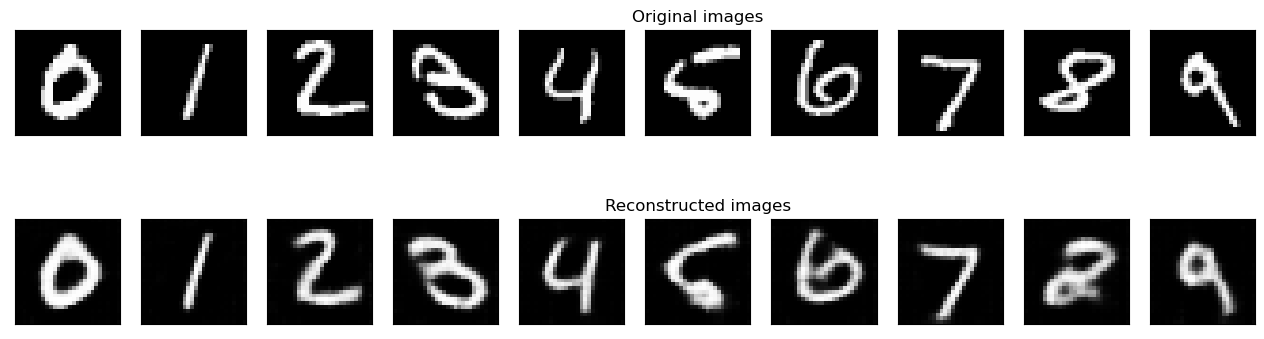

	 partial train loss (single batch): 0.013462
	 partial train loss (single batch): 0.013339
	 partial train loss (single batch): 0.013264
	 partial train loss (single batch): 0.012894
	 partial train loss (single batch): 0.013617
	 partial train loss (single batch): 0.013652
	 partial train loss (single batch): 0.013055
	 partial train loss (single batch): 0.013215
	 partial train loss (single batch): 0.013402
	 partial train loss (single batch): 0.012582
	 partial train loss (single batch): 0.012725
	 partial train loss (single batch): 0.013116
	 partial train loss (single batch): 0.013148
	 partial train loss (single batch): 0.013538
	 partial train loss (single batch): 0.013906
	 partial train loss (single batch): 0.013109
	 partial train loss (single batch): 0.013210
	 partial train loss (single batch): 0.013256
	 partial train loss (single batch): 0.013822
	 partial train loss (single batch): 0.012252
	 partial train loss (single batch): 0.014066
	 partial train loss (single batch

	 partial train loss (single batch): 0.012867
	 partial train loss (single batch): 0.013006
	 partial train loss (single batch): 0.013279
	 partial train loss (single batch): 0.013453
	 partial train loss (single batch): 0.013720
	 partial train loss (single batch): 0.013150

 EPOCH 26/30 	 train loss 0.01322709210216999 	 val loss 0.013816142454743385


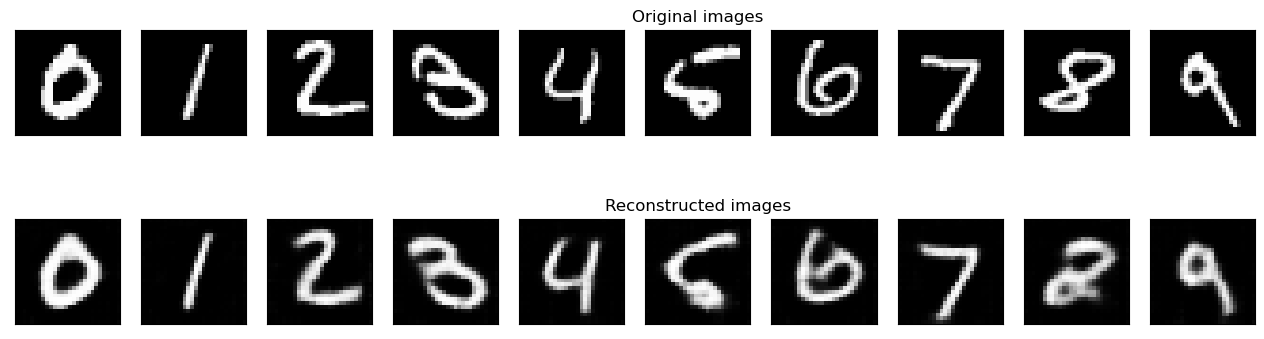

	 partial train loss (single batch): 0.013397
	 partial train loss (single batch): 0.013245
	 partial train loss (single batch): 0.013183
	 partial train loss (single batch): 0.012833
	 partial train loss (single batch): 0.013531
	 partial train loss (single batch): 0.013566
	 partial train loss (single batch): 0.012983
	 partial train loss (single batch): 0.013153
	 partial train loss (single batch): 0.013328
	 partial train loss (single batch): 0.012514
	 partial train loss (single batch): 0.012630
	 partial train loss (single batch): 0.013042
	 partial train loss (single batch): 0.013111
	 partial train loss (single batch): 0.013460
	 partial train loss (single batch): 0.013845
	 partial train loss (single batch): 0.013032
	 partial train loss (single batch): 0.013129
	 partial train loss (single batch): 0.013172
	 partial train loss (single batch): 0.013740
	 partial train loss (single batch): 0.012175
	 partial train loss (single batch): 0.014006
	 partial train loss (single batch

	 partial train loss (single batch): 0.014076
	 partial train loss (single batch): 0.013701
	 partial train loss (single batch): 0.012787
	 partial train loss (single batch): 0.012902
	 partial train loss (single batch): 0.013175
	 partial train loss (single batch): 0.013355
	 partial train loss (single batch): 0.013636
	 partial train loss (single batch): 0.013026

 EPOCH 27/30 	 train loss 0.0131551343947649 	 val loss 0.013742352835834026


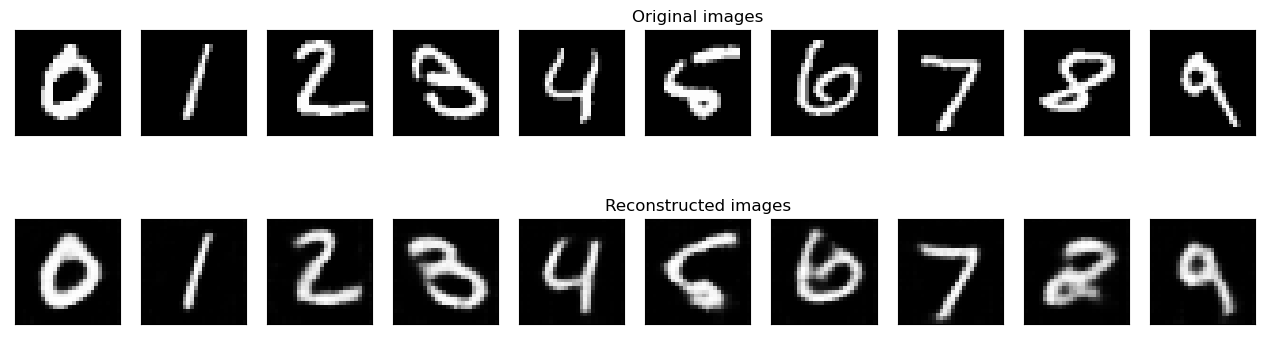

	 partial train loss (single batch): 0.013349
	 partial train loss (single batch): 0.013170
	 partial train loss (single batch): 0.013106
	 partial train loss (single batch): 0.012747
	 partial train loss (single batch): 0.013448
	 partial train loss (single batch): 0.013495
	 partial train loss (single batch): 0.012930
	 partial train loss (single batch): 0.013092
	 partial train loss (single batch): 0.013252
	 partial train loss (single batch): 0.012458
	 partial train loss (single batch): 0.012546
	 partial train loss (single batch): 0.012993
	 partial train loss (single batch): 0.013069
	 partial train loss (single batch): 0.013402
	 partial train loss (single batch): 0.013765
	 partial train loss (single batch): 0.012994
	 partial train loss (single batch): 0.013042
	 partial train loss (single batch): 0.013076
	 partial train loss (single batch): 0.013670
	 partial train loss (single batch): 0.012123
	 partial train loss (single batch): 0.013911
	 partial train loss (single batch

	 partial train loss (single batch): 0.014001
	 partial train loss (single batch): 0.013655
	 partial train loss (single batch): 0.012721
	 partial train loss (single batch): 0.012836
	 partial train loss (single batch): 0.013106
	 partial train loss (single batch): 0.013281
	 partial train loss (single batch): 0.013547
	 partial train loss (single batch): 0.012931

 EPOCH 28/30 	 train loss 0.0130685493350029 	 val loss 0.013654079288244247


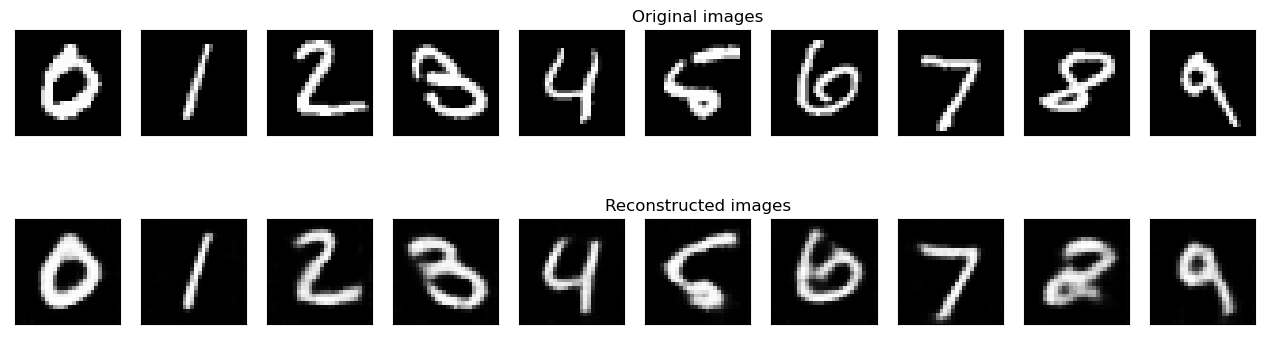

	 partial train loss (single batch): 0.013280
	 partial train loss (single batch): 0.013117
	 partial train loss (single batch): 0.013038
	 partial train loss (single batch): 0.012690
	 partial train loss (single batch): 0.013363
	 partial train loss (single batch): 0.013435
	 partial train loss (single batch): 0.012860
	 partial train loss (single batch): 0.013036
	 partial train loss (single batch): 0.013171
	 partial train loss (single batch): 0.012372
	 partial train loss (single batch): 0.012466
	 partial train loss (single batch): 0.012930
	 partial train loss (single batch): 0.013006
	 partial train loss (single batch): 0.013331
	 partial train loss (single batch): 0.013706
	 partial train loss (single batch): 0.012896
	 partial train loss (single batch): 0.012955
	 partial train loss (single batch): 0.013004
	 partial train loss (single batch): 0.013580
	 partial train loss (single batch): 0.012055
	 partial train loss (single batch): 0.013853
	 partial train loss (single batch

	 partial train loss (single batch): 0.013622
	 partial train loss (single batch): 0.012650
	 partial train loss (single batch): 0.012751
	 partial train loss (single batch): 0.013049
	 partial train loss (single batch): 0.013193
	 partial train loss (single batch): 0.013481
	 partial train loss (single batch): 0.012850

 EPOCH 29/30 	 train loss 0.012993868440389633 	 val loss 0.013551208190619946


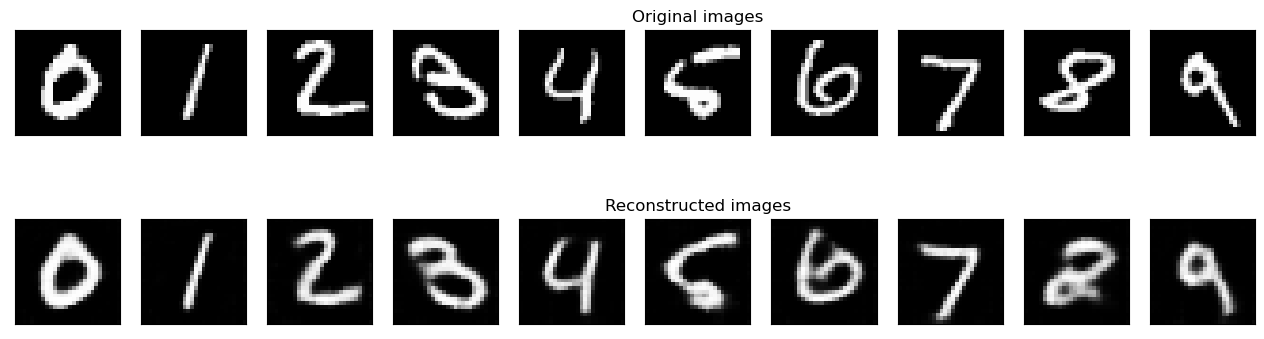

	 partial train loss (single batch): 0.013208
	 partial train loss (single batch): 0.013060
	 partial train loss (single batch): 0.012945
	 partial train loss (single batch): 0.012628
	 partial train loss (single batch): 0.013277
	 partial train loss (single batch): 0.013386
	 partial train loss (single batch): 0.012793
	 partial train loss (single batch): 0.012956
	 partial train loss (single batch): 0.013112
	 partial train loss (single batch): 0.012332
	 partial train loss (single batch): 0.012405
	 partial train loss (single batch): 0.012871
	 partial train loss (single batch): 0.012961
	 partial train loss (single batch): 0.013281
	 partial train loss (single batch): 0.013620
	 partial train loss (single batch): 0.012832
	 partial train loss (single batch): 0.012897
	 partial train loss (single batch): 0.012922
	 partial train loss (single batch): 0.013531
	 partial train loss (single batch): 0.012006
	 partial train loss (single batch): 0.013762
	 partial train loss (single batch

	 partial train loss (single batch): 0.012589
	 partial train loss (single batch): 0.012699
	 partial train loss (single batch): 0.012984
	 partial train loss (single batch): 0.013107
	 partial train loss (single batch): 0.013394
	 partial train loss (single batch): 0.012773

 EPOCH 30/30 	 train loss 0.012926807627081871 	 val loss 0.013486514799296856


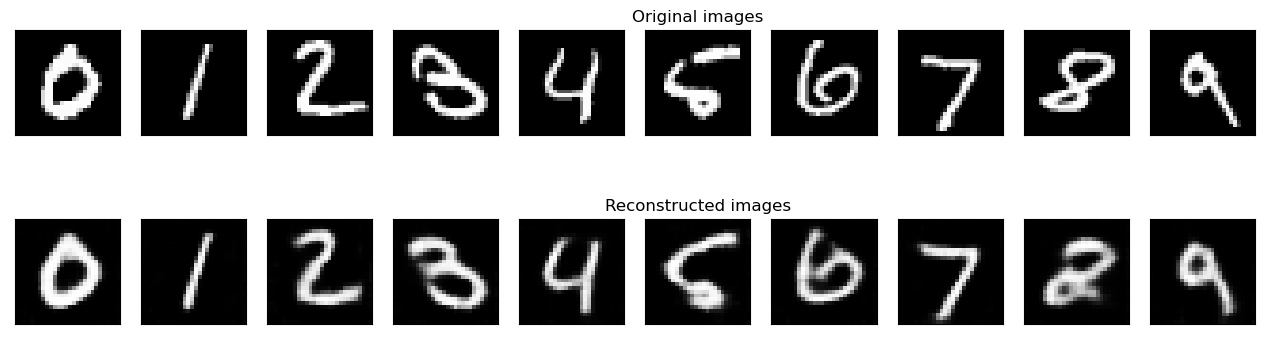

In [14]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss   = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [30]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [16]:
input_data = train_dataset[10][0].to(device)
encoder.forward(input_data[None,:,:])

tensor([[-0.1761, -0.3836,  0.0456, -0.3848, -0.2660,  0.6408,  0.0569, -0.5451,
          0.6175,  0.1942]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Embedding visualization

In [17]:
encoded_samples = []
labels          = []
for sample in (train_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_samples.append(encoded_img)
    labels.append(label)
encoded_samples = np.array(encoded_samples)
labels          = np.array(labels)

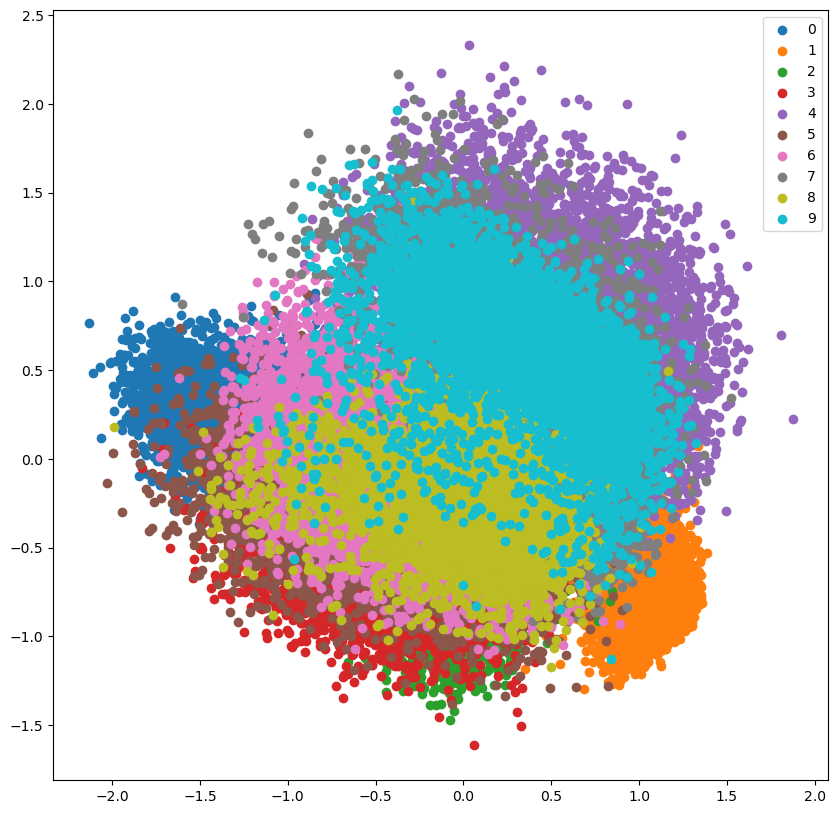

In [18]:
embedding = encoded_samples - np.mean(encoded_samples,axis = 0)
U,s,Vt = np.linalg.svd(embedding, full_matrices = False)
embedding_viz = embedding @ Vt.T[:,:2]
plt.figure(figsize=(10,10))
for u in np.unique(labels):
    plt.scatter(embedding_viz[:,0][labels == u],embedding_viz[:,1][labels == u])
plt.legend([str(u) for u in np.unique(labels.flatten())])

In [19]:
[str(u) for u in np.unique(labels.flatten())]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Simple generative model

In [20]:
import jax
import jax.numpy as jnp

### compute the embedding of every datapoint

In [21]:
N =  3000

In [22]:
embedding_space = jnp.array(encoded_samples)[:N]
minimi          = embedding_space.min(axis = 0)
massimi         = embedding_space.max(axis = 0)
embedding_space = (embedding_space - minimi)/(massimi - minimi)

In [23]:
seed_space = jnp.array(np.random.uniform(size = (N, d)))
seed_space.shape

(3000, 10)

In [50]:
def loss(seed_space,embedding_space):
    return jax.vmap(
        lambda e:
            jnp.min(
                jnp.max( (seed_space - e)**2 , axis = 1)
            )
    )(embedding_space).sum()
loss = jax.jit(loss)
grad = jax.jit(jax.grad(loss))
grad(seed_space,embedding_space)

DeviceArray([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             ...,
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ],
             [ 0.1192283 ,  0.3061861 , -0.29931307, ..., -0.46179086,
               0.        ,  0.62291735],
             [ 0.        ,  0.        ,  0.        , ...,  0.        ,
               0.        ,  0.        ]], dtype=float32)

In [59]:
seed_space = jnp.array(np.random.uniform(size = (N, d)))
original_seed_space = seed_space.copy()
immagini   = []
batch = 10
mom       = np.array(seed_space  * 0.)
for i in range(batch * 10):
    P           = 0.05
    minibatch   = np.random.choice(2, size = len(seed_space), p = [P,1 - P])
    mom[minibatch == 1]         = .999 * mom[minibatch == 1] - 0.0001 * grad(seed_space[minibatch == 1],embedding_space[minibatch == 1])
    seed_space += mom
    immagini.append(seed_space.copy())
    if i % batch == 0:
        print(loss(seed_space,embedding_space))
immagini = jnp.array(immagini)

142.00082
127.13379
101.76497
86.32596
80.31264
76.03947
71.5206
70.05035
67.90908
68.0598


## Cerco il punto dell'embedding piú vicino al seed space trasformato

In [60]:
corresponding_embedding = jnp.array([
        embedding_space[jnp.linalg.norm(s - embedding_space,axis = 1).argmin()]
    for s in seed_space
])

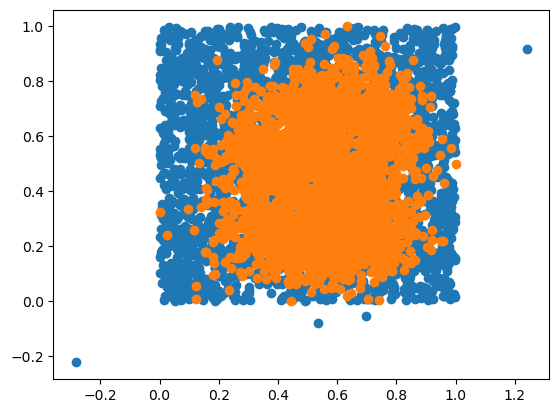

In [61]:
#plt.scatter( original_seed_space[:,0], original_seed_space[:,1])
plt.scatter( seed_space[:,0], seed_space[:,1])
plt.scatter( embedding_space[:,0], embedding_space[:,1])

In [47]:
def genera(seed_space, corresponding_embedding):
    seed = np.random.uniform(size = (seed_space.shape[1]))
    print(seed)
    vicini_seed = seed_space[jnp.linalg.norm(seed_space - seed,axis = 1).argsort()][:len(seed_space.T) + 1] 
    distanze_seed = jnp.linalg.norm(vicini_seed - seed, axis = 1)
    vicini = corresponding_embedding[jnp.linalg.norm(seed_space - seed,axis = 1).argsort()][:len(seed_space.T) + 1]
    ret = (distanze_seed[:,None] * vicini).sum(axis = 0) / distanze_seed.sum()
    print(ret)
    return ret * (massimi - minimi) + minimi
img = decoder.forward(torch.from_numpy(np.array(genera(seed_space,corresponding_embedding)[None,:])).to(device))

[0.6098891  0.95716313 0.92389129 0.66206957 0.65332645 0.84220995
 0.11295808 0.62644559 0.00478874 0.42683049]
[0.589934   0.7298248  0.7157207  0.46284848 0.6042705  0.6858185
 0.45391396 0.5341329  0.4302493  0.40605125]


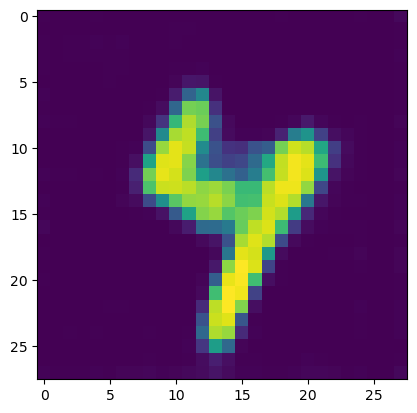

In [48]:
immagine = img.detach().cpu().numpy()[0,0]
plt.imshow(immagine)